# Kann mithilfe einer NLP-unterstützten Methodik festgestellt werden ob ein Amazon Review Positiv, Neutral oder Negativ ist, bzw. kann das angegebene Voting errechnet werden?

- Michael Hermann-Hubler
- Michael Kranl

The used data was created by J. Ni, J. Li, and J. McAuley for „Justifying Recommendations using Distantly-Labeled Reviews and Fine-Grained Aspects“, in Proceedings of the 2019 Conference on mpirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJCNLP), Hong Kong, China, 2019, S. 188–197. doi: 10.18653/v1/D19-1018. 

## Imports

In [ ]:
import sys
!{sys.executable} -m pip install gzinfo
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install wordcloud

In [1]:
# Intel Optimizer for Sklearn
# from sklearnex import patch_sklearn
# patch_sklearn()

# General
import pandas as pd
import numpy as np
from itertools import islice
from sklearn.model_selection import train_test_split

# Download
import urllib.request
import glob
import gzip
import gzinfo
import os
import shutil

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text Preprocessing
from collections import Counter
from keras_preprocessing.text import text_to_word_sequence
import nltk
nltk.download('omw-1.4');
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import re

# Feature Representation
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer

# Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# Prediction
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Metrics
from sklearn.metrics import mean_squared_error

# Set to true on Production
final_Execution = False


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Load Dataset

### Download Sub Dataset

In [2]:
subdatasets = [
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Arts_Crafts_and_Sewing_5.json.gz',
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Industrial_and_Scientific_5.json.gz',
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Luxury_Beauty_5.json.gz',
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Musical_Instruments_5.json.gz'
              ]

def download(x: str):
    urllib.request.urlretrieve(x, '.data/dummy.gz')

    filename = gzinfo.read_gz_info('.data/dummy.gz').fname
    with gzip.open('.data/dummy.gz', 'rb') as f_in:
        with open('.data/' + filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            
    os.remove('.data/dummy.gz')

# only run once as this can take a very long time
if len(os.listdir('.data') ) == 0:
    [download(x) for x in subdatasets]


## Load data

In [3]:
all_files = glob.glob('.data/*')
li = []

for filename in all_files:
    temp_df = pd.read_json(filename, lines=True)
    li.append(temp_df)

df = pd.concat(li, axis=0, ignore_index=True)

## Data Exploration I

In [4]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,True,"03 29, 2016",AIE8N9U317ZBM,0449819906,{'Format:': ' Kindle Edition'},"Zelmira, Ph.D.",Contains some interesting stitches.,Four Stars,1459209600,NaN,NaN
1,5,True,"08 12, 2015",A3ECOW0TWLH9V6,0449819906,{'Format:': ' Paperback'},Dangerous when Cooking,I'm a fairly experienced knitter of the one-co...,My current favorite go-to guide for inspiration,1439337600,18,NaN
2,4,True,"04 5, 2015",A278N8QX9TY2OS,0449819906,{'Format:': ' Paperback'},Just us,Great book but the index is terrible. Had to w...,"lots of great examples, good instructions, col...",1428192000,3,NaN
3,5,True,"10 11, 2014",A123W8HIK76XCN,0449819906,{'Format:': ' Kindle Edition'},Amazon Customer,I purchased the Kindle edition which is incred...,Another little gem by Melissa Leapman,1412985600,NaN,NaN
4,5,True,"05 8, 2014",A2A6MZ2QB4AE0L,0449819906,{'Format:': ' Paperback'},Sustainability,Very well laid out and very easy to read.\n\nT...,Very comprehensive,1399507200,NaN,NaN


In [5]:
df.describe()

,overall,unixReviewTime
count,837226.000000,8.372260e+05
mean,4.524777,1.446987e+09
std,0.953090,4.959673e+07
min,1.000000,1.051402e+09
25%,4.000000,1.418429e+09
50%,5.000000,1.452470e+09
75%,5.000000,1.483402e+09
max,5.000000,1.538525e+09


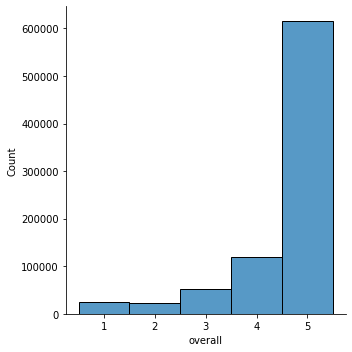

In [6]:
sns.displot(df.overall, discrete=True)

In [7]:
df.groupby('overall').count().reviewText

overall
1     25394
2     23489
3     52973
4    119795
5    615214
Name: reviewText, dtype: int64

The high average overall score means, that we have to split the data differently as we have no normal distibution.

In [8]:
print('Length whole Dataset:', len(df.reviewText))
print('Length Dataset without NA:', len(df.reviewText.dropna()))

Length whole Dataset: 837226
Length Dataset without NA: 836865


There exists missing Data

## Data Cleaning

### Remove unnessesary columns

In [9]:
df = df[['overall', 'reviewText']]

### Remove missing data

In [10]:
df = df.dropna()

### Reduce data to a representative subset
To reduce the data we take random 20.000 samples from each class, without replacement

In [11]:
sampling_size = 20000

li = [
    df[df.overall == 1].sample(sampling_size),
    df[df.overall == 2].sample(sampling_size),
    df[df.overall == 3].sample(sampling_size),
    df[df.overall == 4].sample(sampling_size),
    df[df.overall == 5].sample(sampling_size)
]

df_cleaned = pd.concat(li, axis=0, ignore_index=True)

In [12]:
df_cleaned.describe()

,overall
count,100000.000000
mean,3.000000
std,1.414221
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [13]:
df_cleaned.head()

,overall,reviewText
0,1,"Little piece of junk. Plastic box, plastic jac..."
1,1,This cover does not fit a full size acoustic/e...
2,1,not that great sent back
3,1,No good
4,1,There must be folks out there who like to use ...


## Preprocessing

### Lowercasing

In [14]:
df_lowercase = df_cleaned.copy()
df_lowercase.reviewText = df_lowercase.reviewText.str.lower()
df_lowercase.head()

,overall,reviewText
0,1,"little piece of junk. plastic box, plastic jac..."
1,1,this cover does not fit a full size acoustic/e...
2,1,not that great sent back
3,1,no good
4,1,there must be folks out there who like to use ...


### Remove Special Chars

In [15]:
regex = '[^ A-Za-z]+'

df_spec_cars_removed = df_lowercase.copy()
df_spec_cars_removed.reviewText = df_spec_cars_removed.apply(lambda row: re.sub(regex, '', row.reviewText), axis=1)
df_spec_cars_removed.head()

,overall,reviewText
0,1,little piece of junk plastic box plastic jacks...
1,1,this cover does not fit a full size acousticel...
2,1,not that great sent back
3,1,no good
4,1,there must be folks out there who like to use ...


### Tokenization

In [16]:
df_token = df_spec_cars_removed.copy()
df_token.reviewText = df_token.apply(lambda row: text_to_word_sequence(row.reviewText), axis=1)
df_token.head()

,overall,reviewText
0,1,"[little, piece, of, junk, plastic, box, plasti..."
1,1,"[this, cover, does, not, fit, a, full, size, a..."
2,1,"[not, that, great, sent, back]"
3,1,"[no, good]"
4,1,"[there, must, be, folks, out, there, who, like..."


## Remove seldom used words

In [17]:
df_token_cleaned = df_token.copy()

counts = Counter()
for _, row in df_token_cleaned.iterrows():
    counts.update(row.reviewText)

print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 5:
        del counts[word]
print("num_words after:",len(counts.keys()))


for index, row in df_token_cleaned.iterrows():
    df_token_cleaned.at[index, 'reviewText'] = [x for x in row.reviewText if x in counts.keys()]   

df_token_cleaned.head()

num_words before: 89235
num_words after: 18224


,overall,reviewText
0,1,"[little, piece, of, junk, plastic, box, plasti..."
1,1,"[this, cover, does, not, fit, a, full, size, a..."
2,1,"[not, that, great, sent, back]"
3,1,"[no, good]"
4,1,"[there, must, be, folks, out, there, who, like..."


### Lemmatization 

In [18]:
lemmatizer = WordNetLemmatizer()

df_lemm = df_token_cleaned.copy()
df_lemm.reviewText = df_lemm.apply(lambda row: [lemmatizer.lemmatize(x) for x in row.reviewText], axis=1)
df_lemm.head()

,overall,reviewText
0,1,"[little, piece, of, junk, plastic, box, plasti..."
1,1,"[this, cover, doe, not, fit, a, full, size, ac..."
2,1,"[not, that, great, sent, back]"
3,1,"[no, good]"
4,1,"[there, must, be, folk, out, there, who, like,..."


### Stemming

Stemming ist used additionally to lemtization, because time forms were not normalized

In [19]:
stemmer = PorterStemmer()

df_stemm = df_lemm.copy()
df_stemm.reviewText = df_stemm.apply(lambda row: [stemmer.stem(x) for x in row.reviewText], axis=1)
df_stemm.head()

,overall,reviewText
0,1,"[littl, piec, of, junk, plastic, box, plastic,..."
1,1,"[thi, cover, doe, not, fit, a, full, size, aco..."
2,1,"[not, that, great, sent, back]"
3,1,"[no, good]"
4,1,"[there, must, be, folk, out, there, who, like,..."


### Stopword removal

In [20]:
stopwords_en = stopwords.words('english')

df_removed_stopwords = df_stemm.copy()
df_removed_stopwords.reviewText = df_removed_stopwords.apply(lambda row: [x for x in row.reviewText if x not in stopwords_en and x not in ['\n', '\r']], axis=1)
df_removed_stopwords.head()

,overall,reviewText
0,1,"[littl, piec, junk, plastic, box, plastic, jac..."
1,1,"[thi, cover, doe, fit, full, size, acousticele..."
2,1,"[great, sent, back]"
3,1,[good]
4,1,"[must, folk, like, use, thi, tie, use, paint, ..."


### Define final

In [21]:
#df_final = df_removed_stopwords[df_removed_stopwords.reviewText.map(lambda d: len(d)) > 0]
df_final = df_token_cleaned[df_token_cleaned.reviewText.map(lambda d: len(d)) > 0]

df_final

,overall,reviewText
0,1,"[little, piece, of, junk, plastic, box, plasti..."
1,1,"[this, cover, does, not, fit, a, full, size, a..."
2,1,"[not, that, great, sent, back]"
3,1,"[no, good]"
4,1,"[there, must, be, folks, out, there, who, like..."
...,...,...
99995,5,"[husbands, new, hobby]"
99996,5,"[great, light, table, i, use, it, all, the, time]"
99997,5,"[purple, my, granddaughters, favorite, color, ..."
99998,5,"[well, made, and, large, compared, to, my, oth..."


## Data Exploration II

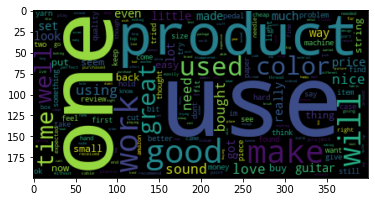

In [22]:
word_list = df_final.reviewText.tolist()
word_list = [i for j in word_list for i in j]

word_list_text = ' '.join(word_list)

wordcloud = WordCloud().generate(word_list_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

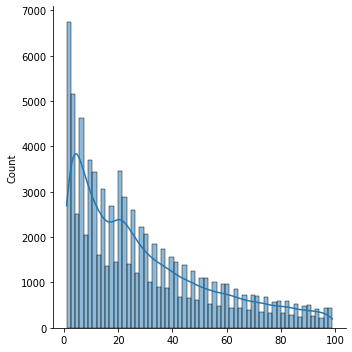

In [23]:
word_counts = [df_final.reviewText.apply(len)][0]
word_counts = [x for x in word_counts if x < 100]

sns.displot(word_counts, kde=True)

In [24]:
[x for x in df_final.reviewText if len(x) < 5][:10]


[['no', 'good'],
 ['doesnt', 'work'],
 ['no', 'noticeable', 'effect'],
 ['fine'],
 ['overpriced'],
 ['overheats', 'waste', 'of', 'money'],
 ['useless'],
 ['ok'],
 ['returned', 'it'],
 ['didnt', 'fit']]

These results with just one word seem plausible, thus they will be included

## Feature Representation

### n-Gram

In [25]:
n = 3
ngram = ngrams(df_final.reviewText, n)

df_ngram = df_final.copy()
df_ngram['ngram'] = df_ngram.reviewText

df_ngram.loc[df_ngram.reviewText.apply(len) >= n, 'ngram'] = [list(ngrams(x, n)) for x in df_ngram.reviewText if len(x) >= n]

df_ngram

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,overall,reviewText,ngram
0,1,"[little, piece, of, junk, plastic, box, plasti...","[(little, piece, of), (piece, of, junk), (of, ..."
1,1,"[this, cover, does, not, fit, a, full, size, a...","[(this, cover, does), (cover, does, not), (doe..."
2,1,"[not, that, great, sent, back]","[(not, that, great), (that, great, sent), (gre..."
3,1,"[no, good]","[no, good]"
4,1,"[there, must, be, folks, out, there, who, like...","[(there, must, be), (must, be, folks), (be, fo..."
...,...,...,...
99995,5,"[husbands, new, hobby]","[(husbands, new, hobby)]"
99996,5,"[great, light, table, i, use, it, all, the, time]","[(great, light, table), (light, table, i), (ta..."
99997,5,"[purple, my, granddaughters, favorite, color, ...","[(purple, my, granddaughters), (my, granddaugh..."
99998,5,"[well, made, and, large, compared, to, my, oth...","[(well, made, and), (made, and, large), (and, ..."


### TF-IDF

In [26]:
def take(n, iterable):
    return list(islice(iterable, n))

vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=(lambda x:x),
    preprocessor=(lambda x:x),
    token_pattern=None
)

vectorizer.fit(df_final.reviewText)
take(10, vectorizer.vocabulary_.items())

[('little', 8934),
 ('piece', 11422),
 ('of', 10548),
 ('junk', 8333),
 ('plastic', 11558),
 ('box', 1709),
 ('jacks', 8176),
 ('all', 401),
 ('i', 7502),
 ('think', 16061)]

## Clustering

### Preparing Sample
A sample is needed because of memory Reasons

In [27]:
if final_Execution:
    df_sample = df_final
else:
    df_sample = df_final.sample(n=(int)(sampling_size/20))
X = vectorizer.transform(df_sample.reviewText)
X.toarray()

array([[0.12048125, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.12644411, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## KMeans + PCA

In [28]:
# do Ellbow Plot only for final Execution, as this takes a very long time

if final_Execution:
    distortions = []
    K = range(1,20)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X)
        distortions.append(kmeanModel.inertia_)    

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()



Upper Limit of 20, because the Optimum (~35) cannot be displayed


Cluster 0
my,very,to,a,love,it,not,for,and,the

Cluster 1
color,nice,and,not,well,expected,quality,product,very,good

Cluster 2
not,what,for,and,this,a,to,the,it,i

Cluster 3
artwork,beads,mic,little,reeds,for,price,works,product,great

Cluster 4
for,this,of,is,i,and,it,a,to,the


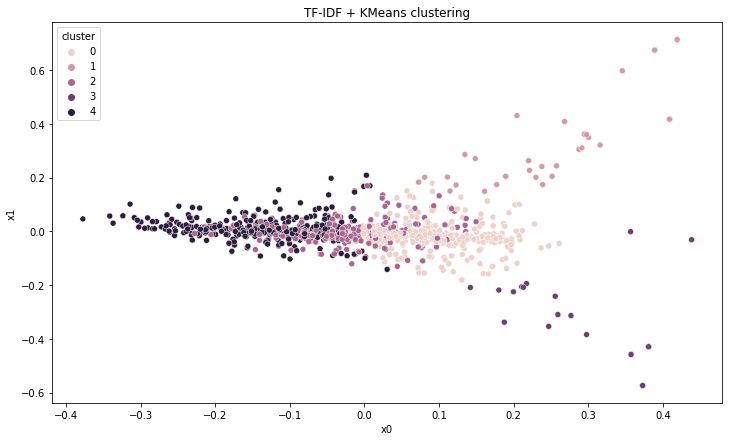

In [29]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_

pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(X.toarray())

df_sample['cluster'] = clusters
df_sample['x0'] = pca_vecs[:, 0]
df_sample['x1'] = pca_vecs[:, 1]

get_top_keywords(10)

plt.figure(figsize=(12, 7))
plt.title("TF-IDF + KMeans clustering")
sns.scatterplot(data=df_sample, x='x0', y='x1', hue='cluster')
plt.show()

### TSNE

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 103.150108
[t-SNE] KL divergence after 1000 iterations: 1.426876


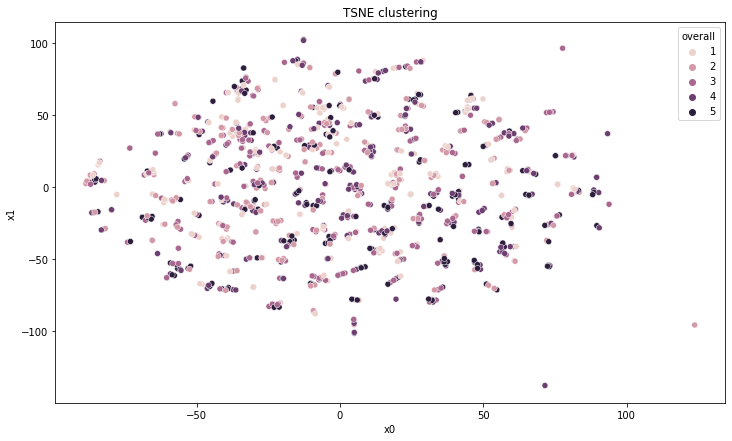

In [30]:
model = TSNE(n_components=2, verbose=1, perplexity=2)
z = model.fit_transform(X)

#df_sample['cluster'] = clusters
df_sample['x0'] = z[:,0]
df_sample['x1'] = z[:,1]

plt.figure(figsize=(12, 7))
plt.title("TSNE clustering")
sns.scatterplot(data=df_sample, x='x0', y='x1', hue='overall')
plt.show()

## UMAP

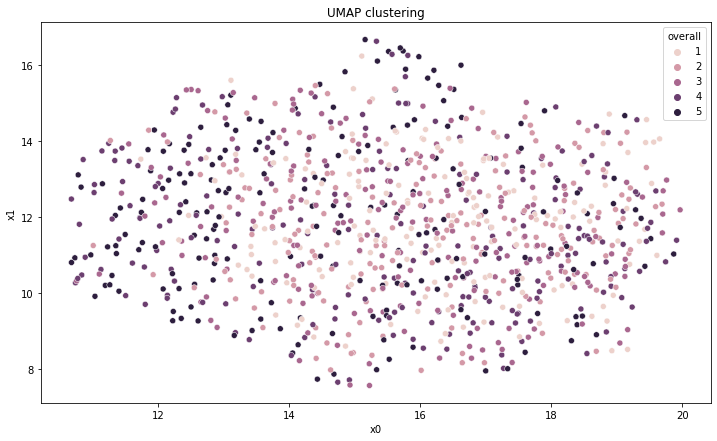

In [31]:
reducer = UMAP(n_neighbors=20, min_dist=0.8)
v_embed = reducer.fit_transform(X)

df_sample['x0'] = v_embed[:,0]
df_sample['x1'] = v_embed[:,1]

plt.figure(figsize=(12, 7))
plt.title("UMAP clustering")
sns.scatterplot(x="x0", y="x1", data=df_sample, hue='overall')
plt.show()

# Preditction

## Pytorch Preprocessing

In [32]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

def encode_sentence(tokenized, vocab2index, N=70):
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

df_sample['encoded'] = df_sample['reviewText'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))

x = df_sample.encoded
y = df_sample.overall

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


## Pytorch Dataset

In [54]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.x = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        #print(self.x)
        return torch.from_numpy(self.x[idx][0].astype(np.int32)).to(device), self.y[idx], self.x[idx][1]
        #return torch.from_numpy(self.x[idx][0].astype(np.int32)), self.y[idx], self.x[idx][1]

train_ds = ReviewDataset(x_train, y_train)
val_ds = ReviewDataset(x_val, y_val)
test_ds = ReviewDataset(x_test, y_test)

## Pytorch Training Loop

In [40]:
def train_model_regr(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long().to(device)
            y = y.float().to(device)
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.mse_loss(y_pred, y.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss = validation_metrics_regr(model, val_dl)
        if i % 5 == 1:
            print("train mse %.3f val rmse %.3f" % (sum_loss/total, val_loss))

def validation_metrics_regr (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.float()
        y_hat = model(x, l).cpu()
        loss = np.sqrt(F.mse_loss(y_hat, y.unsqueeze(-1)).item())
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    return sum_loss/total

batch_size = 5000
vocab_size = len(words)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size)

## Pytorch Model

In [51]:
class LSTM(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])
        
lstm_model =  LSTM(vocab_size, 1000, 500)
lstm_model.to(device)

LSTM(
  (embeddings): Embedding(18226, 1000, padding_idx=0)
  (lstm): LSTM(1000, 500, batch_first=True)
  (linear): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [52]:
train_model_regr(lstm_model, epochs=500, lr=0.01)

train mse 5.608 val rmse 6.586
train mse 5.480 val rmse 2.494
train mse 6.147 val rmse 2.513
train mse 2.082 val rmse 1.630
train mse 1.709 val rmse 1.512
train mse 1.523 val rmse 1.465
train mse 1.509 val rmse 1.470
train mse 1.480 val rmse 1.479
train mse 1.477 val rmse 1.483
train mse 1.465 val rmse 1.481
train mse 1.463 val rmse 1.485
train mse 1.459 val rmse 1.489
train mse 1.458 val rmse 1.489
train mse 1.457 val rmse 1.486
train mse 1.456 val rmse 1.486
train mse 1.462 val rmse 1.495
train mse 1.472 val rmse 1.506
train mse 1.451 val rmse 1.489
train mse 1.451 val rmse 1.494
train mse 1.447 val rmse 1.498
train mse 1.438 val rmse 1.491
train mse 1.405 val rmse 1.494
train mse 1.308 val rmse 1.487
train mse 1.221 val rmse 1.488
train mse 1.122 val rmse 1.487
train mse 0.903 val rmse 1.527
train mse 0.738 val rmse 1.581
train mse 0.605 val rmse 1.580
train mse 0.517 val rmse 1.624
train mse 0.418 val rmse 1.641
train mse 0.335 val rmse 1.701
train mse 0.300 val rmse 1.759
train ms

In [60]:
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)

for x, y, l in test_dl:
    x = x.long().to(device)
    y = y.float().to(device)
    y_pred = lstm_model(x, l)
    



tensor([4.1228], device='cuda:0', grad_fn=<SelectBackward0>)
3
